[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# Streaming

## Review

In module 2, covered a few ways to customize graph state and memory.
 
We built up to a Chatbot with external memory that can sustain long-running conversations. 

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways. 

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution. 

In [1]:
import os, getpass, sys
from langchain_anthropic import ChatAnthropic

#Import API Keys(storing them all in a seperate file so i run into less issues with git)
_root = "/home/zjc1002/Mounts/code/"
_langsmith_trace = 'true'
_langsmith_project = 'zjc_custom_v1'
_anthropic_model = 'claude-3-haiku-20240307'
_temparate = 0
_max_tokens = 4000
_streaming = True
_system_message = None
_db_path = "/home/zjc1002/Mounts/data/langgraph_memory/state_db/example1.db"
# This is a basic config to enable tracing of conversations and  utilization of memory
_config = {'configurable': {'thread_id':"1"}}

# Custom functions
sys.path.append(_root)
from  admin.api_keys import _api_keys
from admin.sys_ops import _set_env
from langgraph_projects.tools import get_weather, get_date, multiply, add, divide

# This anthropic and internet tool requires  API key to be set as a environment variable(s)
for api_key in ["TAVILY_API_KEY","ANTHROPIC_API_KEY",'OPENAI_API_KEY','LANGSMITH_API_KEY']:
    _set_env(api_key
            ,value =  _api_keys[api_key])

Note that we use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x. 

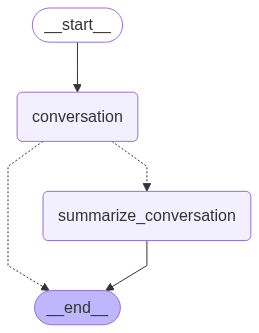

In [2]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig
import langchain_core
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

from typing import Dict, List, Union, Literal
# LLM
model =  ChatAnthropic(
    model=_anthropic_model,
    temperature=_temparate,
    max_tokens=_max_tokens,
    streaming=_streaming,
    verbose=True,
)


# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig
               ) -> Dict[str, langchain_core.messages.ai.AIMessage]:
    """_summary_

    Args:
        state (State): _description_
        config (RunnableConfig): _description_

    Returns:
        Dict[str, Union[str, List[RemoveMessage]]]: _description_
    """
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State) -> Dict:
    """Summarize the conversation so far.
    This is done by taking the last 6 messages and creating a summary of them.
    The summary is then added to the state, and the messages are removed from the state.
    Args:
        state (State): _description_

    Returns:
        Dict[str, Union[str, List[RemoveMessage]]]: _description_
    """
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation","__end__"]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return "__end__"

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation"
                               , should_continue
                               , {
                                   "summarize_conversation": "summarize_conversation",
                                   "__end__": END
                               })
                               
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

It's nice to meet you, Lance! I'm Claude, an AI assistant created by Anthropic. How can I help you today?
================================== Ai Message ==================================

Your name is Lance, as you introduced yourself at the beginning of our conversation.
================================== Ai Message ==================================

That's great that you're a fan of the 49ers! I don't have a strong allegiance to any particular sports teams, but I can certainly appreciate the passion and excitement that comes with being a fan. Do you have a favorite player or moment from the 49ers that you really enjoy?


### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [5]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)
    

{'conversation': {'messages': AIMessage(content="Okay, got it - your name is Lance. It's nice to meet you again, Lance! I'm always happy to chat about sports or any other topics you're interested in. What do you enjoy most about being a 49ers fan?", additional_kwargs={}, response_metadata={'model_name': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None}, id='run--b8659fca-e0c2-43a0-bd09-e223c8a23855-0', usage_metadata={'input_tokens': 154, 'output_tokens': 60, 'total_tokens': 214, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})}}
{'summarize_conversation': {'summary': 'Here is a summary of the conversation so far:\n\nThe conversation began with you introducing yourself as Lance. I then introduced myself as Claude, an AI assistant. \n\nYou expressed that you are a fan of the 49ers football team. I acknowledged this and asked if you had a favorite player or moment as a 49ers fan.\n\nYou then repeated that your name is Lance, even though I had alr

Let's now just print the state update.

In [5]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Okay, I understand you are introducing yourself as Lance again. As I mentioned before, I already knew your name was Lance from our earlier conversation. Is there anything else you'd like to discuss? I'm happy to continue our conversation about the 49ers or any other topics you're interested in.


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [6]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):

    #NOTE: the keys in the event are the keys specified in t he graph State
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

#get a static state view, to decompose and undersstand the elements of the state
input_message = HumanMessage(content="can you find me the best resturant in Cary NC.")
e = graph.stream({"messages": [input_message]}, config, stream_mode="values")


================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

It's nice to meet you, Lance! I'm Claude, an AI assistant created by Anthropic. How can I help you today?
---------------------------------------------------------------------------


In [ ]:
#unpacking an event
type(e)

#unpack generator into list
d = []
for event in e: 
    d.append(event)

#list all attributes associated with each  event 
vars(d[0]['messages'][0])

{'content': 'can you find me the best resturant in Cary NC.',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'e38fb98f-4667-4df1-865e-257fdb7a22d9',
 'example': False}

### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [6]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")

# Stream each token as it is generated
async for event in graph.astream_events({"messages": [input_message]},
                                         config, version="v2"):
    
    print(event)


{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me about the 49ers NFL team', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '6810397c-6ff5-454b-adb0-4523378c5a8e', 'metadata': {'thread_id': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me about the 49ers NFL team', additional_kwargs={}, response_metadata={}, id='787b888b-fbc6-4573-83eb-34502e650dc8')]}}, 'name': 'conversation', 'tags': ['graph:step:1'], 'run_id': 'b82bd159-9874-4e34-88e4-e58df06530b2', 'metadata': {'thread_id': '3', 'langgraph_step': 1, 'langgraph_node': 'conversation', 'langgraph_triggers': ('branch:to:conversation',), 'langgraph_path': ('__pregel_pull', 'conversation'), 'langgraph_checkpoint_ns': 'conversation:966bf1cd-37e8-47ca-d6ec-fd221f3f3b17'}, 'parent_ids': ['6810397c-6ff5-454b-adb0-4523378c5a8e']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[H

In [6]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")

# Stream each token as it is generated
async for event in graph.astream_events({"messages": [input_message]},
                                         config, version="v2"):
    
    print(
        f"""Node: {event['metadata'].get('langgraph_node','')
                   }. Type: {event['event']
                             }. Name: {event['name']}
                             """
                             )

Node: . Type: on_chain_start. Name: LangGraph
                             
Node: conversation. Type: on_chain_start. Name: conversation
                             
Node: conversation. Type: on_chat_model_start. Name: ChatAnthropic
                             
Node: conversation. Type: on_chat_model_stream. Name: ChatAnthropic
                             
Node: conversation. Type: on_chat_model_stream. Name: ChatAnthropic
                             
Node: conversation. Type: on_chat_model_stream. Name: ChatAnthropic
                             
Node: conversation. Type: on_chat_model_stream. Name: ChatAnthropic
                             
Node: conversation. Type: on_chat_model_stream. Name: ChatAnthropic
                             
Node: conversation. Type: on_chat_model_stream. Name: ChatAnthropic
                             
Node: conversation. Type: on_chat_model_stream. Name: ChatAnthropic
                             
Node: conversation. Type: on_chat_model_stream. Na

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [7]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")

#NOTE: version is just a flag to indicate the version of the API you are using
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):

    # Get chat model tokens from a particular node 
    # NOTE: this is a hack to get the tokens from the conversation node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_name': 'claude-3-haiku-20240307'}, id='run--2b41a74a-7950-4da5-b82c-7b884d64377d', usage_metadata={'input_tokens': 16, 'output_tokens': 1, 'total_tokens': 17, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})}
{'chunk': AIMessageChunk(content='Here', additional_kwargs={}, response_metadata={}, id='run--2b41a74a-7950-4da5-b82c-7b884d64377d')}
{'chunk': AIMessageChunk(content=' are some key facts about the San Francisco 49ers NFL', additional_kwargs={}, response_metadata={}, id='run--2b41a74a-7950-4da5-b82c-7b884d64377d')}
{'chunk': AIMessageChunk(content=' team:\n\n- The 49ers are', additional_kwargs={}, response_metadata={}, id='run--2b41a74a-7950-4da5-b82c-7b884d64377d')}
{'chunk': AIMessageChunk(content=' based in Santa Clara, California an', additional_kwargs={}, response_metadata={}, id='run--2b41a74a-7950-4da5-b82c-7b884d64377d')}
{'chunk': AIMessageChunk(content='d play their home g

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [8]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|Here| are some key facts about the San Francisco| 49ers NFL team:

-| The 49ers are based in Santa| Clara, California and play their home games| at Levi's Stadium.|

- They are members of the National Football| Conference (NFC) West division in the| National Football League (NFL).

- The| 49ers were founded in 1|946 as a charter member of the| All-America Football Conference (AA|FC) and joined the NFL| in 1950.

- They| have won 5 Super Bowl championships|, which ties them for the secon|d-most Super Bowl wins along with the Dallas| Cowboys. Their Super Bowl wins came in| 1981, 1984|, 1988, 1989|, and 1994.

- Some| of their most famous players include quarter|backs Joe Montana and Steve Young, wide| receiver Jerry Rice, and linebacker Patrick Willis.

-| The 49ers had a dominant run in the |1980s and early 1990s|, making the playoffs 16| times in 18 seasons an|d winning 5 Super Bowls|.

- In recent| years, the 49ers have ha|d some ups and downs, but they made| it to the Super Bowl in 

### Streaming with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

The LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation). 

In [ ]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [28]:
from langgraph_sdk import get_client

# This is the URL of the local development server
#URL = "http://127.0.0.1:2024"
URL = "http://localhost:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [11]:
assistants

[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'graph_id': 'dynamic_breakpoints',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'dynamic_breakpoints',
  'created_at': '2025-05-18T14:26:48.148326+00:00',
  'updated_at': '2025-05-18T14:26:48.148326+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'created_at': '2025-05-18T14:26:48.145604+00:00',
  'updated_at': '2025-05-18T14:26:48.145604+00:00',
  'version': 1,
  'description': None}]

Let's [stream `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), like before.

In [29]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '1f0340e0-943f-68ee-8911-6c7c2be3fbdb', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '986d2340-5337-42b1-8cf8-6e607d622f4a', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '986d2340-5337-42b1-8cf8-6e607d622f4a', 'example': False}, {'content': [{'id': 'toolu_01CarHKyYNdEyzceU2ELLcYB', 'input': {}, 'name': 'multiply', 'type': 'tool_use', 'index': 0, 'partial_json': '{"a": 2, "b": 3}'}], 'additional_kwargs': {}, 'response_metadata': {'model_name': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None}, 'type': 'ai', 'name': None, 'id': 'run--a522c6b0-9eda-4665-b237-2901a5c2ccf4-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b

The streamed objects have: 

* `event`: Type
* `data`: State

In [31]:
import numpy as np
import pandas as pd
np.set_printoptions(linewidth=100)
pd.set_option('display.max_columns', 50) 
pd.set_option('display.width', 120)

In [32]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        #convert_to_messages is a function that converts the messages to a list of messages
        # This is useful for debugging and understanding the messages
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={} response_metadata={} id='d9c78a39-3b07-49be-aa9b-823ebb1ee3c9'
content=[{'id': 'toolu_019i9zF5UmenbgGQjYQPaKgK', 'input': {}, 'name': 'multiply', 'type': 'tool_use', 'index': 0, 'partial_json': '{"a": 2, "b": 3}'}] additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 532, 'output_tokens': 72, 'total_tokens': 604, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}} response_metadata={'model_name': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None} id='run--2df475e5-c433-4582-87dc-647c9573f733-0' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'toolu_019i9zF5UmenbgGQjYQPaKgK', 'type': 'tool_call'}]
content='6' name='multiply' id='bcaaab01-0048-46e6-bdf8-3b3976fcd4fd' tool_call_id='toolu_019i9zF5UmenbgGQjYQPaKgK'
content=[{'text': 'The result of multiplying 2 and 3 is 6.', 'type': 'text', 'index': 0}] additional_kwargs={'invalid_tool_calls': [], 'usage_metadata

### There are some new streaming mode that are only supported via the API.

For example, we can [use `messages` mode](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/) to better handle the above case!

This mode currently assumes that you have a `messages` key in your graph, which is a list of messages.

All events emitted using `messages` mode have two attributes:

* `event`: This is the name of the event
* `data`: This is data associated with the event



##### NOTE:  if the LLM you want to use is not implemented / configured as part of Langchain chat model interface, you can still stream the data from the LLM API. Please reference this doucmentation for details on how to implement custom message streaming from non langgraph configured LLMs: https://langchain-ai.github.io/langgraph/how-tos/streaming/#use-with-any-llm

In [229]:
def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']} \
                , Function: {call['name']} \
                , Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

# Create a new thread
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")


eventlist  = {}

async for event in client.runs.stream(
    
    #ID of the conversation thread
    thread["thread_id"]

    #Name of the assistant / agent as specified in the name of the file containing the graph logic: /home/zjc1002/Mounts/code/langgraph_projects/langchain-academy/module-3/studio/agent.py
    , assistant_id="agent"

    #Input message to the assistant
    , input={"messages": [input_message]}

    #Stream mode to use. This can be "values" or "messages"
    #NOTE: values is the default mode and will return the values of the messages, 'messages' will return the messages as they are generated
    , stream_mode="messages"):

    #count total number of each type of event as they are streamed 
    eventlist[event.event] = eventlist.get(event.event,0) + 1

    print(f"EVENT TYPE: {event.event}") 
    
    # MEATADATA EVENT 
    #print the event type and the number of times it has been streamed
    if event.event == "metadata":

        #event is a dictionary that contains the metadata of the event
        #un-usable keys: count(), index()
        #usable keys: event(), data()
        print(f"METADATA KEYS: {[v for v in dir(event) if not (v.startswith('_') or v.endswith('_'))]}")
        print(f"METADATA DATA KEYS: {[v for v in event.data.keys() if not (v.startswith('_') or v.endswith('_'))]}")
        print(f"Run ID: {event.data['run_id']}")
        print(f"Attempt: {event.data['attempt']}")
        print('\n')
        print("-" * 50)
    # MESSAGE METADATA EVENT
    #messages/metatadata is a dic that contains the metadata of the messages
    elif event.event == "messages/metadata" :

        if eventlist[event.event] == 1:
            print(f"EVENT KEYS: {[v for v in dir(event) if not (v.startswith('_') or v.endswith('_'))]}")        


            # traversing the keys of the messages/metadata dictionary
            # Using ANSI escape codes for bold text
            print('\n')
            print(f"\033[1m{event.event}\033[0m has the following keys: {[x for x in event.data.keys()]}")  
            print('\n')
            #each nested dictionary contains the metadata of the messages contained within the metadata key (its the only key)
            print(f" The values for each parent key {[x for x in event.data.keys()]} is a nested dictionary with the following keys: {[x for x in event.data[next(iter(event.data))].keys()]}")
            print('\n')
            print(f"\033[1m  Metadata child dictionary contains following metadata(printing keys): \033[0m {[x for x in event.data[next(iter(event.data))][next(iter(event.data[next(iter(event.data))]))].keys()]}")
            print('\n')

        print(f"\n \033[1m  metadata child dictionary @ step \033[0m")
        
        # For a nested dictionary structure
        for outer_key, inner_dict in event.data.items():

            for inner_key, inner_value in inner_dict.items():
                print(f"    parent key: {outer_key} -> child key: {inner_key}")
                print("\n")

                for k,v in inner_value.items():
                    print(f"  {k} -> {v}")
        print("-" * 50)
        
    #STREAMING TOKEN EVENT 
    elif event.event == "messages/partial" :
        print(f"TOTAL OCCURANCES OF {str(event.event).upper()}: {eventlist[event.event]}")
        
        #messages/partial is a list of dictionaries that contains the metadata of the messages
        for data_item in event.data:
            if 'role' in data_item and data_item['role'] == 'user':
                print(f"Human: {data_item['content']}") 
            else:
                
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})
                
                # Process the AI tokens being streamed if they exist
                if ((content not in ["",[]])):
                    if isinstance(content, list):

                        # If content is a list, print each item
                        for item in content:
                            if 'text' in item: 
                                print(f"AI: {item.get('text','NO TEXT')}")

                
                if tool_calls:
                    print(f"TOOL CALLS: {format_tool_calls(tool_calls)}")
        
                if invalid_tool_calls:
                    print("INVALID TOOL CALLS:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("stop_reason", "N/A")
                    print(f"RESPONSE METADATA (FINISH REASON) - {finish_reason}")
                    
        print("-" * 50)

EVENT TYPE: metadata
METADATA KEYS: ['count', 'data', 'event', 'index']
METADATA DATA KEYS: ['run_id', 'attempt']
Run ID: 1f034da3-d820-6bc4-9c27-8abfa5b076d1
Attempt: 1


--------------------------------------------------
EVENT TYPE: messages/metadata
EVENT KEYS: ['count', 'data', 'event', 'index']


messages/metadata has the following keys: ['run--bff36e6a-5a58-4a8c-a685-2aadc24df42e']


 The values for each parent key ['run--bff36e6a-5a58-4a8c-a685-2aadc24df42e'] is a nested dictionary with the following keys: ['metadata']


  Metadata child dictionary contains following metadata(printing keys):  ['created_by', 'graph_id', 'assistant_id', 'run_attempt', 'langgraph_version', 'langgraph_plan', 'langgraph_host', 'langgraph_api_url', 'user-agent', 'x-request-id', 'langgraph_auth_user_id', 'langgraph_request_id', 'run_id', 'thread_id', 'user_id', 'langgraph_step', 'langgraph_node', 'langgraph_triggers', 'langgraph_path', 'langgraph_checkpoint_ns', 'checkpoint_ns', 'ls_provider', 'ls_mode

In [223]:
for _i in event.data:
    print(_i['response_metadata'])
    print(_i['response_metadata']['stop_reason'])
    print(_i['response_metadata']['stop_sequence'])


{'model_name': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None}
end_turn
None


In [37]:
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)
    print(event.data)

metadata
{'run_id': '1f034b12-d48a-6c24-8fec-ff6284084bd2', 'attempt': 1}
messages/metadata
{'run--c5e457ce-cf42-46ea-886f-6612e0141438': {'metadata': {'created_by': 'system', 'graph_id': 'agent', 'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca', 'run_attempt': 1, 'langgraph_version': '0.4.3', 'langgraph_plan': 'developer', 'langgraph_host': 'self-hosted', 'langgraph_api_url': 'http://127.0.0.1:2024', 'user-agent': 'langgraph-sdk-py/0.1.66', 'x-request-id': '982a17c4-4136-4bd0-a8d3-c47053743b3e', 'langgraph_auth_user_id': '', 'langgraph_request_id': '982a17c4-4136-4bd0-a8d3-c47053743b3e', 'run_id': '1f034b12-d48a-6c24-8fec-ff6284084bd2', 'thread_id': 'af1c77b5-73a0-4e1b-b4f4-33fd106f8d5b', 'user_id': '', 'langgraph_step': 6, 'langgraph_node': 'assistant', 'langgraph_triggers': ['branch:to:assistant'], 'langgraph_path': ['__pregel_pull', 'assistant'], 'langgraph_checkpoint_ns': 'assistant:cc7499bf-c779-f089-8e1b-16594635a153', 'checkpoint_ns': 'assistant:cc7499bf-c779-f089-8e1b-16

We can see a few events: 

* `metadata`: metadata about the run
* `messages/complete`: fully formed message 
* `messages/partial`: chat model tokens

You can dig further into the types [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages).

Now, let's show how to stream these messages. 

We'll define a helper function for better formatting of the tool calls in messages.

In [36]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']} \
                , Function: {call['name']} \
                , Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 1f0340ee-6045-6c1b-89ec-28655dc0848b
--------------------------------------------------
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: [{'id': 'toolu_01SQir834n8Q4nZASUkGtP9c', 'input': {}, 'name': 'multiply', 'type': 'tool_use', 'index': 0}]
Tool Calls:
Tool Call ID: toolu_01SQir834n8Q4nZASUkGtP9c                 , Function: multiply                 , Arguments: {}
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: [{'id': 'toolu_01SQir834n8Q4nZASUkGtP9c', 'input': {}, 'name': 'multiply', 'type': 'tool_use', 'index': 0, 'partial_json': ''}]
Tool Calls:
Tool Call ID: toolu_01SQir834n8Q4nZASUkGtP9c                 , Function: multiply                 , Arguments: {}
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: [{'id': 'toolu_01SQir834n8Q4nZASUkGtP9c', 'input': {}, 'name': 'multiply', 'type': 'tool_use', 'index': 0, 'partial_json': 